## Step 0: Set up

In [25]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import StandardScaler

In [2]:
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [4]:
# Folder structure
DATA_RAW_DIR = "data/raw"
DATA_PROCESSED_DIR = "data/processed"
EDA_DIR = "outputs/eda"

os.makedirs(DATA_RAW_DIR, exist_ok=True)
os.makedirs(DATA_PROCESSED_DIR, exist_ok=True)
os.makedirs(EDA_DIR, exist_ok=True)

print("Folders ready")
print("Raw data dir:", DATA_RAW_DIR)
print("Processed dir:", DATA_PROCESSED_DIR)
print("EDA outputs dir:", EDA_DIR)

Folders ready
Raw data dir: data/raw
Processed dir: data/processed
EDA outputs dir: outputs/eda


## Step 1: Load and merge the Excel files and create `ticker_id`

Load stocks + bitcoin Excel files, make sure columns match, clean types, merge everything, and create a stable `ticker_id`.

In [7]:
# Paths to the raw Excel files 
stocks_path = os.path.join(DATA_RAW_DIR, "stocks.xlsx")
btc_path    = os.path.join(DATA_RAW_DIR, "bitcoin.xlsx")

# Load the Excel files
df_stocks = pd.read_excel(stocks_path)
df_btc    = pd.read_excel(btc_path)

# Standardize column names so both files share the same schema:
#    date, ticker, close, tweet
def standardize_columns(df):
    df = df.copy()
    df.columns = [c.strip().lower() for c in df.columns]
    rename_map = {
        "date": "date",
        "ticker": "ticker",
        "closing price": "close",
        "closing_price": "close",
        "close": "close",
        "price": "close",
        "tweet": "tweet",
        "text": "tweet",
    }
    return df.rename(columns={c: rename_map.get(c, c) for c in df.columns})

df_stocks = standardize_columns(df_stocks)
df_btc    = standardize_columns(df_btc)

# Basic cleaning:
#    - parse dates
#    - make sure close is numeric
#    - make sure ticker/tweet are clean strings
#    - drop rows missing date/ticker/close (a tweet can be empty)
def basic_clean(df):
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df["ticker"] = df["ticker"].astype(str).str.strip()
    df["close"] = pd.to_numeric(df["close"], errors="coerce")
    df["tweet"] = df["tweet"].astype(str).fillna("").str.strip()
    return df.dropna(subset=["date", "ticker", "close"])

df_stocks = basic_clean(df_stocks)
df_btc    = basic_clean(df_btc)

# Merge stocks + bitcoin into a single tweet-level dataframe
df_all = pd.concat([df_stocks, df_btc], ignore_index=True)

# Create a stable integer id per ticker (used for grouping + embeddings later)
df_all["ticker_id"], uniques = pd.factorize(df_all["ticker"], sort=True)
id_to_ticker = dict(enumerate(uniques))  # for readable outputs later

# Sort by ticker and date for time-series 
df_all = df_all.sort_values(["ticker_id", "date"]).reset_index(drop=True)

print("Tweet-level rows:", len(df_all))
print("Num tickers:", df_all["ticker_id"].nunique())
df_all.head()


Tweet-level rows: 10825
Num tickers: 6


,date,ticker,close,tweet,ticker_id
0,2023-01-02,AAPL,250.270331,watch downtrend positive risk strong uptrend d...,0
1,2023-01-02,AAPL,250.270331,today report report bad sell volume price toda...,0
2,2023-01-02,AAPL,250.270331,miss miss beat uptrend today bad,0
3,2023-01-02,AAPL,250.270331,report watch volume today trend volume negativ...,0
4,2023-01-02,AAPL,250.270331,downtrend report buy signal volume price,0


## Step 2: Light tweet cleaning and sentiment per tweet 

We clean tweets a little (URLs/mentions/$tickers) and compute a sentiment score for each tweet.
Light cleaning  should reduce noise, and the exploratory analysis help us sanity-check sentiment and tweet activity before modeling.


In [10]:
# Tweet cleaning 
def clean_tweet(text: str) -> str:
    text = str(text).lower()

    # remove urls
    text = re.sub(r"http\S+|www\.\S+", " ", text)

    # remove mentions like @user
    text = re.sub(r"@\w+", " ", text)

    # remove cashtags like $AAPL
    text = re.sub(r"\$\w+", " ", text)

    # keep the hashtag word but remove '#'
    text = text.replace("#", "")

    # normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

df_all["tweet_clean"] = df_all["tweet"].apply(clean_tweet)

# Sentiment scoring (we use VADER)
vader = SentimentIntensityAnalyzer()

def sent_score(text: str) -> float:
    return float(vader.polarity_scores(text)["compound"])  # [-1, 1]

    
# Sentiment per tweet 
df_all["sentiment"] = df_all["tweet_clean"].apply(sent_score)


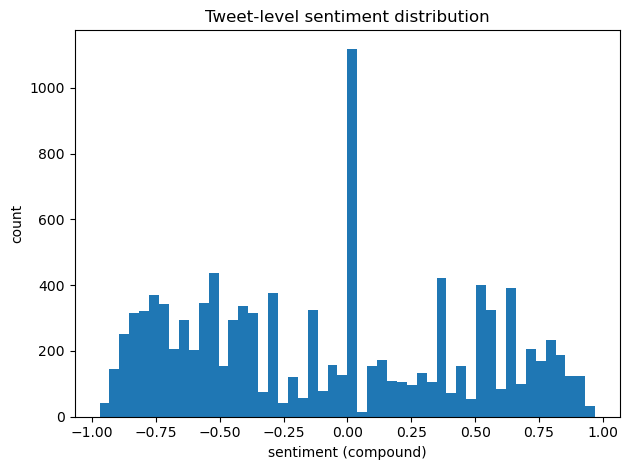

In [11]:
# Tweet-level sentiment distribution
plt.figure()
plt.hist(df_all["sentiment"], bins=50)
plt.title("Tweet-level sentiment distribution")
plt.xlabel("sentiment (compound)")
plt.ylabel("count")
plt.tight_layout()
plt.savefig(os.path.join(EDA_DIR, "tweet_sentiment_hist.png"))
plt.show()

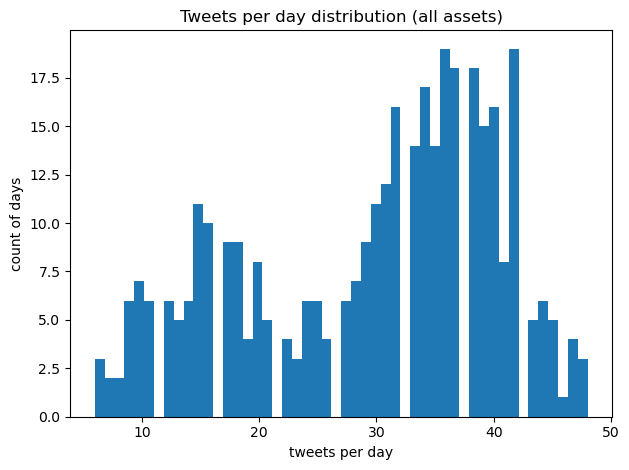

In [12]:
# Tweets per day distribution 
tweets_per_day = df_all.groupby("date")["tweet_clean"].count()

plt.figure()
plt.hist(tweets_per_day, bins=50)
plt.title("Tweets per day distribution (all assets)")
plt.xlabel("tweets per day")
plt.ylabel("count of days")
plt.tight_layout()
plt.savefig(os.path.join(EDA_DIR, "tweets_per_day_hist.png"))
plt.show()


In [13]:
print("Saved EDA plots to:", EDA_DIR)
df_all[["date", "ticker", "close", "tweet_clean", "sentiment"]].head()

Saved EDA plots to: outputs/eda


,date,ticker,close,tweet_clean,sentiment
0,2023-01-02,AAPL,250.270331,watch downtrend positive risk strong uptrend d...,0.8555
1,2023-01-02,AAPL,250.270331,today report report bad sell volume price toda...,-0.8020
2,2023-01-02,AAPL,250.270331,miss miss beat uptrend today bad,-0.6908
3,2023-01-02,AAPL,250.270331,report watch volume today trend volume negativ...,-0.5719
4,2023-01-02,AAPL,250.270331,downtrend report buy signal volume price,0.0000


From the sentiment plot, we see tweets spread from very negative to very positive, but with a big spike around 0. For us, that means a lot of tweets are basically neutral (not strongly emotional), which is normal with short texts and VADER. So the signal won’t always be super obvious, and the models will need to learn from small changes in the daily average sentiment.
From the tweets-per-day plot, tweet activity isn’t constant: most days we have around 30–40 tweets, but some days are much quieter and some are busier. For us, this matters because daily sentiment is more reliable when there are more tweets, and tweet volume itself might carry information (attention/uncertainty). Overall, the data looks reasonable and ready to move to daily aggregation + target creation.

## Step 3: Aggregate to daily (Date × ticker) 

We collapse tweet-level data into one row per **day and ticker**, with daily close + daily sentiment stats.
As all our models work at the daily level, we need a clean daily dataset before building labels and sequences.


In [14]:
# Aggregate to one row per (date, ticker_id)
daily = (
    df_all
    .groupby(["date", "ticker_id"], as_index=False)
    .agg(
        close=("close", "last"),
        n_tweets=("tweet_clean", "count"),
        sent_mean=("sentiment", "mean"),
        sent_std=("sentiment", "std"),
    )
)

# std is NaN if only 1 tweet that day -> set to 0
daily["sent_std"] = daily["sent_std"].fillna(0.0)

# Keep sorted
daily = daily.sort_values(["ticker_id", "date"]).reset_index(drop=True)

print("Daily rows:", len(daily))
daily.head()


Daily rows: 1770


,date,ticker_id,close,n_tweets,sent_mean,sent_std
0,2023-01-02,0,250.270331,8,-0.188262,0.587617
1,2023-01-03,0,248.541521,5,0.392240,0.523683
2,2023-01-04,0,249.929330,4,-0.115825,0.619169
3,2023-01-05,0,248.505651,8,-0.327738,0.587933
4,2023-01-06,0,248.905790,3,-0.171667,0.552577


In [15]:
coverage = (
    daily.groupby("ticker_id")
    .agg(
        n_days=("date", "nunique"),
        avg_tweets_per_day=("n_tweets", "mean"),
        median_tweets_per_day=("n_tweets", "median"),
        sent_mean_avg=("sent_mean", "mean"),
        sent_mean_std=("sent_mean", "std"),
    )
    .reset_index()
)

coverage["ticker"] = coverage["ticker_id"].map(id_to_ticker)
coverage = coverage[["ticker_id", "ticker", "n_days",
                     "avg_tweets_per_day", "median_tweets_per_day",
                     "sent_mean_avg", "sent_mean_std"]]

coverage.to_csv(os.path.join(EDA_DIR, "coverage_by_ticker.csv"), index=False)
print("Saved:", os.path.join(EDA_DIR, "coverage_by_ticker.csv"))
coverage

Saved: outputs/eda/coverage_by_ticker.csv


,ticker_id,ticker,n_days,avg_tweets_per_day,median_tweets_per_day,sent_mean_avg,sent_mean_std
0,0,AAPL,260,4.884615,5.0,-0.085856,0.320695
1,1,BTC,365,7.687671,8.0,-0.090532,0.295226
2,2,ETH,365,7.813699,8.0,-0.085346,0.300779
3,3,MSFT,260,4.923077,5.0,-0.050196,0.320016
4,4,SAP,260,5.119231,5.0,-0.074094,0.310643
5,5,TSLA,260,4.946154,5.0,-0.091814,0.327754


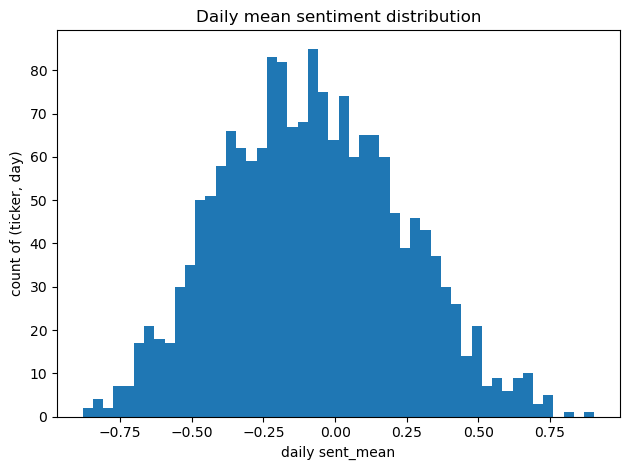

In [16]:
# Daily sentiment distribution 
plt.figure()
plt.hist(daily["sent_mean"], bins=50)
plt.title("Daily mean sentiment distribution")
plt.xlabel("daily sent_mean")
plt.ylabel("count of (ticker, day)")
plt.tight_layout()
plt.savefig(os.path.join(EDA_DIR, "daily_sent_mean_hist.png"))
plt.show()

In [17]:
daily.to_csv(os.path.join(DATA_PROCESSED_DIR, "daily.csv"), index=False)
print("Saved:", os.path.join(DATA_PROCESSED_DIR, "daily.csv"))

Saved: data/processed/daily.csv


## Step 4: 3-day impact as a fixed horizon target

We assume today’s tweets can affect the market over the next few days, so we set the label using a fixed horizon `H` (e.g., 3). For each ticker, we compare today’s close with the close **H days later** and set `y=1` if the price is higher after H days, otherwise `y=0`.

This is a simple way to model a “delayed reaction” without changing the rest of the pipeline. We use only information available up to day *t* as features, but we evaluate whether the market moved up or down over the next H days.



In [21]:
# Horizon
H = 3  

# Future close at t+H (per ticker)
daily["close_fwd"] = daily.groupby("ticker_id")["close"].shift(-H)

# Label: direction over the next H days
daily["y"] = (daily["close_fwd"] > daily["close"]).astype(int)

# Simple market features 
daily["ret"] = daily.groupby("ticker_id")["close"].pct_change()
daily["ret_lag1"] = daily.groupby("ticker_id")["ret"].shift(1)

# Lag sentiment + tweet volume features (yesterday)
daily["sent_mean_lag1"] = daily.groupby("ticker_id")["sent_mean"].shift(1)
daily["sent_std_lag1"]  = daily.groupby("ticker_id")["sent_std"].shift(1)
daily["n_tweets_lag1"]  = daily.groupby("ticker_id")["n_tweets"].shift(1)

# Feature columns shared by all models
feature_cols = [
    "sent_mean", "sent_std", "n_tweets",
    "sent_mean_lag1", "sent_std_lag1", "n_tweets_lag1",
    "ret", "ret_lag1"
]

# Keep only clean rows
daily_model = daily.dropna(subset=["close_fwd", "y"] + feature_cols).copy()
daily_model = daily_model.sort_values(["ticker_id", "date"]).reset_index(drop=True)

print(f"Horizon H={H} days ahead")
print("Rows ready for modeling:", len(daily_model))
daily_model[["date", "ticker_id", "close", "close_fwd", "y"]].head()

Horizon H=3 days ahead
Rows ready for modeling: 1740


,date,ticker_id,close,close_fwd,y
0,2023-01-04,0,249.929330,251.779316,1
1,2023-01-05,0,248.505651,252.456450,1
2,2023-01-06,0,248.905790,253.564952,1
3,2023-01-09,0,251.779316,253.755199,1
4,2023-01-10,0,252.456450,253.149420,1


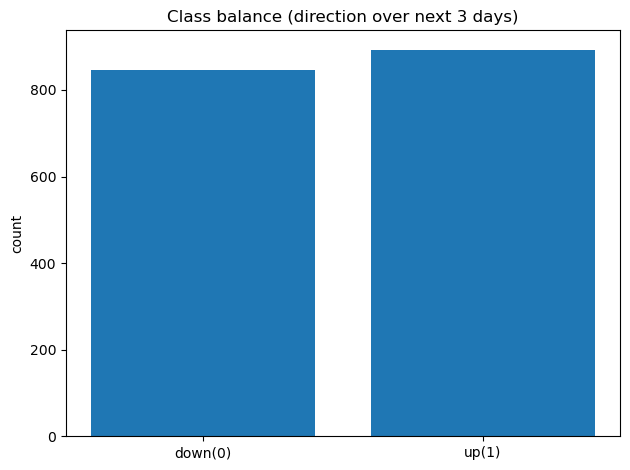

In [22]:
y_counts = daily_model["y"].value_counts().sort_index()

plt.figure()
plt.bar(["down(0)", "up(1)"], [y_counts.get(0, 0), y_counts.get(1, 0)])
plt.title(f"Class balance (direction over next {H} days)")
plt.ylabel("count")
plt.tight_layout()
plt.savefig(os.path.join(EDA_DIR, f"class_balance_H{H}.png"))
plt.show()

In [23]:
out_path = os.path.join(DATA_PROCESSED_DIR, f"daily_model_H{H}.csv")
daily_model.to_csv(out_path, index=False)
print("Saved:", out_path)

Saved: data/processed/daily_model_H3.csv


We look at the class balance for our label “price direction over the next 3 days”.
The two bars (down vs up) are very similar, with up(1) slightly higher than down(0).
For us, this is good news: the dataset is not heavily imbalanced, so the models won’t “cheat” by always predicting one class.
It also means that accuracy is a meaningful metric here (if it was super imbalanced, accuracy could look good even with a useless model).
So overall: the target looks well-behaved and fair for training and comparing our models.

## Step 5: Time split (train/val/test) and scale numeric features

We split the daily modeling table by time into train/val/test, then we standardize numeric features using only the training set.
Time splits avoid seeing the future, and scaling helps all models train more stably (especially neural nets).


In [26]:
# Time split based on unique dates (we do the same split for all tickers)
dates = np.array(sorted(daily_model["date"].unique()))
n_dates = len(dates)

train_end = int(0.70 * n_dates)
val_end   = int(0.85 * n_dates)

train_dates = set(dates[:train_end])
val_dates   = set(dates[train_end:val_end])
test_dates  = set(dates[val_end:])

train_df = daily_model[daily_model["date"].isin(train_dates)].copy()
val_df   = daily_model[daily_model["date"].isin(val_dates)].copy()
test_df  = daily_model[daily_model["date"].isin(test_dates)].copy()

print("Rows (train/val/test):", len(train_df), len(val_df), len(test_df))

Rows (train/val/test): 1214 270 256


In [28]:
#Scale numeric features
scaler = StandardScaler()
scaler.fit(train_df[feature_cols])

train_df[feature_cols] = scaler.transform(train_df[feature_cols])
val_df[feature_cols]   = scaler.transform(val_df[feature_cols])
test_df[feature_cols]  = scaler.transform(test_df[feature_cols])

In [29]:
# Save split info (so all models are comparable)
split_info = {
    "H": H,  # horizon we used for the label
    "train_start": str(dates[0]),
    "train_end": str(dates[train_end - 1]),
    "val_start": str(dates[train_end]),
    "val_end": str(dates[val_end - 1]),
    "test_start": str(dates[val_end]),
    "test_end": str(dates[-1]),
    "n_train_dates": int(train_end),
    "n_val_dates": int(val_end - train_end),
    "n_test_dates": int(n_dates - val_end),
}

pd.DataFrame([split_info]).to_csv(os.path.join(DATA_PROCESSED_DIR, f"split_info_H{H}.csv"), index=False)
print("Saved:", os.path.join(DATA_PROCESSED_DIR, f"split_info_H{H}.csv"))

train_df.head()

Saved: data/processed/split_info_H3.csv


,date,ticker_id,close,n_tweets,sent_mean,sent_std,close_fwd,y,ret,ret_lag1,sent_mean_lag1,sent_std_lag1,n_tweets_lag1
0,2023-01-04,0,249.929330,-0.773337,-0.119046,0.889539,251.779316,1,0.328189,-0.377675,1.494744,0.328697,-0.412121
1,2023-01-05,0,248.505651,0.667693,-0.792766,0.706664,252.456450,1,-0.310654,0.328183,-0.120045,0.888342,-0.772059
2,2023-01-06,0,248.905790,-1.133594,-0.296580,0.499666,253.564952,1,0.103145,-0.309220,-0.793569,0.705269,0.667695
3,2023-01-09,0,251.779316,0.667693,-0.681055,-0.395029,253.755199,1,0.665776,0.103646,-0.297527,0.498046,-1.131998
4,2023-01-10,0,252.456450,-0.773337,1.124513,0.467478,253.149420,1,0.164266,0.665009,-0.681891,-0.397620,0.667695


## Step 6: Save clean outputs for all models 

We save the daily splits for logreg/MLP, and we also build and save sequences for CNN/LSTM.
Every model can load the same prepared data, so comparisons are fair.

* Daily models (logreg/MLP): use rows `(date, ticker_id)` with `feature_cols`
* Sequence models (CNN/LSTM): use lookback windows of length `L`


In [30]:
# Save daily splits (for logistic regression + MLP)
train_df.to_csv(os.path.join(DATA_PROCESSED_DIR, f"train_daily_H{H}.csv"), index=False)
val_df.to_csv(os.path.join(DATA_PROCESSED_DIR, f"val_daily_H{H}.csv"), index=False)
test_df.to_csv(os.path.join(DATA_PROCESSED_DIR, f"test_daily_H{H}.csv"), index=False)

print("Saved daily splits")

Saved daily splits


In [31]:
# Sequence building (for CNN/LSTM)
#    - CNN expects (N, C, L)
#    - LSTM expects (N, L, C)
LOOKBACK = 14

def make_sequences(df, feature_cols, lookback=14, mode="cnn"):
    """
    mode="cnn"  -> X shape (N, C, L)
    mode="lstm" -> X shape (N, L, C)
    """
    df = df.sort_values(["ticker_id", "date"]).reset_index(drop=True)

    X_list, tid_list, y_list, meta_list = [], [], [], []

    for tid, g in df.groupby("ticker_id", sort=False):
        g = g.sort_values("date")

        Xg = g[feature_cols].to_numpy(dtype=np.float32)  # (T, C)
        yg = g["y"].to_numpy(dtype=np.int64)             # (T,)
        dates = g["date"].to_numpy()

        for t in range(lookback - 1, len(g)):
            window = Xg[t - lookback + 1 : t + 1]  # (L, C)

            if mode == "cnn":
                window = window.T                  # (C, L)

            X_list.append(window)
            tid_list.append(int(tid))
            y_list.append(int(yg[t]))
            meta_list.append((int(tid), dates[t]))

    X = np.stack(X_list, axis=0)
    tid = np.array(tid_list, dtype=np.int64)
    y = np.array(y_list, dtype=np.int64)
    meta = pd.DataFrame(meta_list, columns=["ticker_id", "date"])

    return X, tid, y, meta


In [33]:
# Build and save CNN sequences
X_train_cnn, tid_train_cnn, y_train_cnn, meta_train_cnn = make_sequences(train_df, feature_cols, LOOKBACK, mode="cnn")
X_val_cnn,   tid_val_cnn,   y_val_cnn,   meta_val_cnn   = make_sequences(val_df, feature_cols, LOOKBACK, mode="cnn")
X_test_cnn,  tid_test_cnn,  y_test_cnn,  meta_test_cnn  = make_sequences(test_df, feature_cols, LOOKBACK, mode="cnn")

np.savez_compressed(
    os.path.join(DATA_PROCESSED_DIR, f"cnn_sequences_H{H}_L{LOOKBACK}.npz"),
    X_train=X_train_cnn, tid_train=tid_train_cnn, y_train=y_train_cnn,
    X_val=X_val_cnn, tid_val=tid_val_cnn, y_val=y_val_cnn,
    X_test=X_test_cnn, tid_test=tid_test_cnn, y_test=y_test_cnn
)
meta_train_cnn.to_csv(os.path.join(DATA_PROCESSED_DIR, f"cnn_meta_train_H{H}_L{LOOKBACK}.csv"), index=False)
meta_val_cnn.to_csv(os.path.join(DATA_PROCESSED_DIR, f"cnn_meta_val_H{H}_L{LOOKBACK}.csv"), index=False)
meta_test_cnn.to_csv(os.path.join(DATA_PROCESSED_DIR, f"cnn_meta_test_H{H}_L{LOOKBACK}.csv"), index=False)

print("Saved CNN sequences")

Saved CNN sequences


In [ ]:
# Build and save LSTM sequences
X_train_lstm, tid_train_lstm, y_train_lstm, meta_train_lstm = make_sequences(train_df, feature_cols, LOOKBACK, mode="lstm")
X_val_lstm,   tid_val_lstm,   y_val_lstm,   meta_val_lstm   = make_sequences(val_df, feature_cols, LOOKBACK, mode="lstm")
X_test_lstm,  tid_test_lstm,  y_test_lstm,  meta_test_lstm  = make_sequences(test_df, feature_cols, LOOKBACK, mode="lstm")

np.savez_compressed(
    os.path.join(DATA_PROCESSED_DIR, f"lstm_sequences_H{H}_L{LOOKBACK}.npz"),
    X_train=X_train_lstm, tid_train=tid_train_lstm, y_train=y_train_lstm,
    X_val=X_val_lstm, tid_val=tid_val_lstm, y_val=y_val_lstm,
    X_test=X_test_lstm, tid_test=tid_test_lstm, y_test=y_test_lstm
)
meta_train_lstm.to_csv(os.path.join(DATA_PROCESSED_DIR, f"lstm_meta_train_H{H}_L{LOOKBACK}.csv"), index=False)
meta_val_lstm.to_csv(os.path.join(DATA_PROCESSED_DIR, f"lstm_meta_val_H{H}_L{LOOKBACK}.csv"), index=False)
meta_test_lstm.to_csv(os.path.join(DATA_PROCESSED_DIR, f"lstm_meta_test_H{H}_L{LOOKBACK}.csv"), index=False)

print("Saved LSTM sequences ")